Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [2]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning  # 수정된 부분
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [16]:
import matplotlib.pyplot as plt


def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)

# Chapter 10 - Monte Carlo Simulations in Finance

Monte Carlo 시뮬레이션은 반복적인 무작위 샘플링을 사용하여 확률적으로 해석될 수 있는 문제를 해결하는 일련의 계산 알고리즘입니다. 금융 분야에서 Monte Carlo 시뮬레이션이 인기를 끌게 된 이유 중 하나는 적분을 정확하게 추정하는 데 사용할 수 있기 때문입니다. Monte Carlo 시뮬레이션의 주요 아이디어는 샘플 경로(가능한 시나리오/결과)의 다수를 생성하는 것입니다. 이 경로는 지정된 시간 단계 수로 나뉘며, 이를 통해 연속 시간을 근사화합니다. 이 과정을 이산화라고 하며, 그 목표는 금융 상품 가격 결정이 일어나는 연속적인 시간을 근사하는 것입니다.

이 모든 시뮬레이션 샘플 경로에서 나온 결과는 사건이 발생한 비율, 마지막 단계에서 금융 상품의 평균 가치 등을 계산하는 데 사용할 수 있습니다. 역사적으로 Monte Carlo 방법의 주요 문제는 이러한 계산에 많은 컴퓨팅 파워가 필요하다는 점이었습니다. 하지만 현재는 데스크탑 컴퓨터나 노트북에서도 상당히 고급 시뮬레이션을 실행할 수 있으며, 컴퓨팅 파워가 부족할 경우 클라우드 컴퓨팅과 같은 강력한 프로세서를 사용할 수 있습니다.

이 장을 끝낼 무렵에는 다양한 시나리오와 작업에서 Monte Carlo 방법을 사용하는 방법을 알게 될 것입니다. 일부는 처음부터 직접 시뮬레이션을 작성하고, 다른 경우에는 현대적인 Python 라이브러리를 사용하여 과정을 더욱 쉽게 만들 것입니다. Monte Carlo 방법의 유연성 덕분에, 이 방법은 다양한 문제에 적용할 수 있습니다. 예를 들어 폐쇄형 솔루션이 없는 파생상품(미국/이국적인 옵션) 가격 책정, 포트폴리오의 불확실성(예: VaR(Value-at-Risk) 및 ES(Expected Shortfall)) 추정, 그리고 리스크 관리에서 스트레스 테스트를 수행하는 것 등이 있습니다. 이 장에서는 이러한 문제들 중 일부를 해결하는 방법을 보여줄 것입니다.

이 장에서 다루는 내용은 다음과 같습니다:

- 기하학적 Brownian 운동을 사용하여 주식 가격 역학 시뮬레이션
- 시뮬레이션을 사용하여 유럽식 옵션 가격 책정
- Least Squares Monte Carlo를 사용하여 미국식 옵션 가격 책정
- QuantLib을 사용하여 미국식 옵션 가격 책정
- 장벽 옵션 가격 책정
- Monte Carlo를 사용하여 VaR(Value-at-Risk) 추정

## 10.1 Simulating stock price dynamics using geometric Brownian motion

**기하학적 Brownian 운동을 사용하여 주식 가격 역학 시뮬레이션**

주식 가격 시뮬레이션은 특히 옵션을 포함한 많은 파생 상품의 평가에서 중요한 역할을 합니다. 이러한 시뮬레이션은 가격 움직임의 무작위성 때문에 확률 미분 방정식(SDE)에 의존합니다. 확률 과정이 다음의 기하학적 Brownian 운동(GBM)을 따를 때, 이는 다음의 SDE를 만족합니다:

$
dS_t = \mu S_t dt + \sigma S_t dW_t
$

여기서, 우리는 다음을 갖습니다:

- $S_t$: 주가
- $\mu$: 드리프트 계수, 즉, 주어진 기간 동안의 평균 수익률 또는 순간 기대 수익률
- $\sigma$: 확산 계수, 즉, 드리프트에서 얼마나 많은 변동성이 있는지를 나타냅니다.
- $W_t$: Brownian 운동
- $d$: 고려된 시간 증가에 따라 변수의 변화

우리는 Brownian 운동의 성질을 깊이 탐구하지는 않을 것입니다. 이는 이 책의 범위를 벗어나기 때문입니다. 간단히 말해, Brownian 증가는 표준 정규 난수 ($rv \sim N(0, 1)$와 시간 증가의 제곱근의 곱으로 계산됩니다. 우리는 Brownian 증가의 누적 합계를 취하여 Brownian 경로를 얻습니다.

위에서 언급한 SDE는 폐쇄형 솔루션을 갖는 몇 안 되는 방정식 중 하나입니다:

$
S(t) = S_0 e^{\left(\mu - \frac{1}{2} \sigma^2\right) t + \sigma W_t}
$

여기서 $S_0 = S(0)$는 이 과정의 초기 값이며, 이 경우 초기 주가입니다. 이 방정식은 시간 $t$에서의 주가와 초기 주가 사이의 관계를 나타냅니다.

시뮬레이션을 위해 우리는 다음의 재귀 공식을 사용할 수 있습니다:

$
S(t_{i+1}) = S(t_i) \exp \left(\left(\mu - \frac{1}{2} \sigma^2 \right) (t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i} Z_{i+1} \right)
$

여기서 $Z_i$는 표준 정규 난수이며 $i = 0, 1, \dots, T-1$는 시간 지수를 나타냅니다. 이 명세는 $W$의 증가가 독립적이고 정규 분포임을 전제로 합니다. 이 공식을 더 잘 이해하기 위해서는 Euler의 이산화 방법을 참고하시기 바랍니다.

GBM은 평균 복귀 및 시간 의존 변동성을 고려하지 않기 때문에 채권 가격보다는 주식 가격을 시뮬레이션하는 데 자주 사용됩니다. 채권 가격은 장기적으로 명목가로의 복귀 경향을 보이기 때문입니다.

이 절에서는 Monte Carlo 방법과 GBM을 사용하여 2021년 데이터를 기반으로 2022년 1월 동안 IBM 주식 가격의 한 달 후 경로를 시뮬레이션합니다.

### How to do it...

1. Import the libraries:

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf

2. Download data from Yahoo Finance:

In [6]:
df = yf.download("IBM", 
                 start="2021-01-01", 
                 end="2022-01-31",)
                #  adjusted=True)

[*********************100%***********************]  1 of 1 completed


3. Calculate and plot daily returns:

**Step 2와 3에서**, 우리는 IBM의 주식 가격을 다운로드하고 간단한 수익률을 계산합니다. 

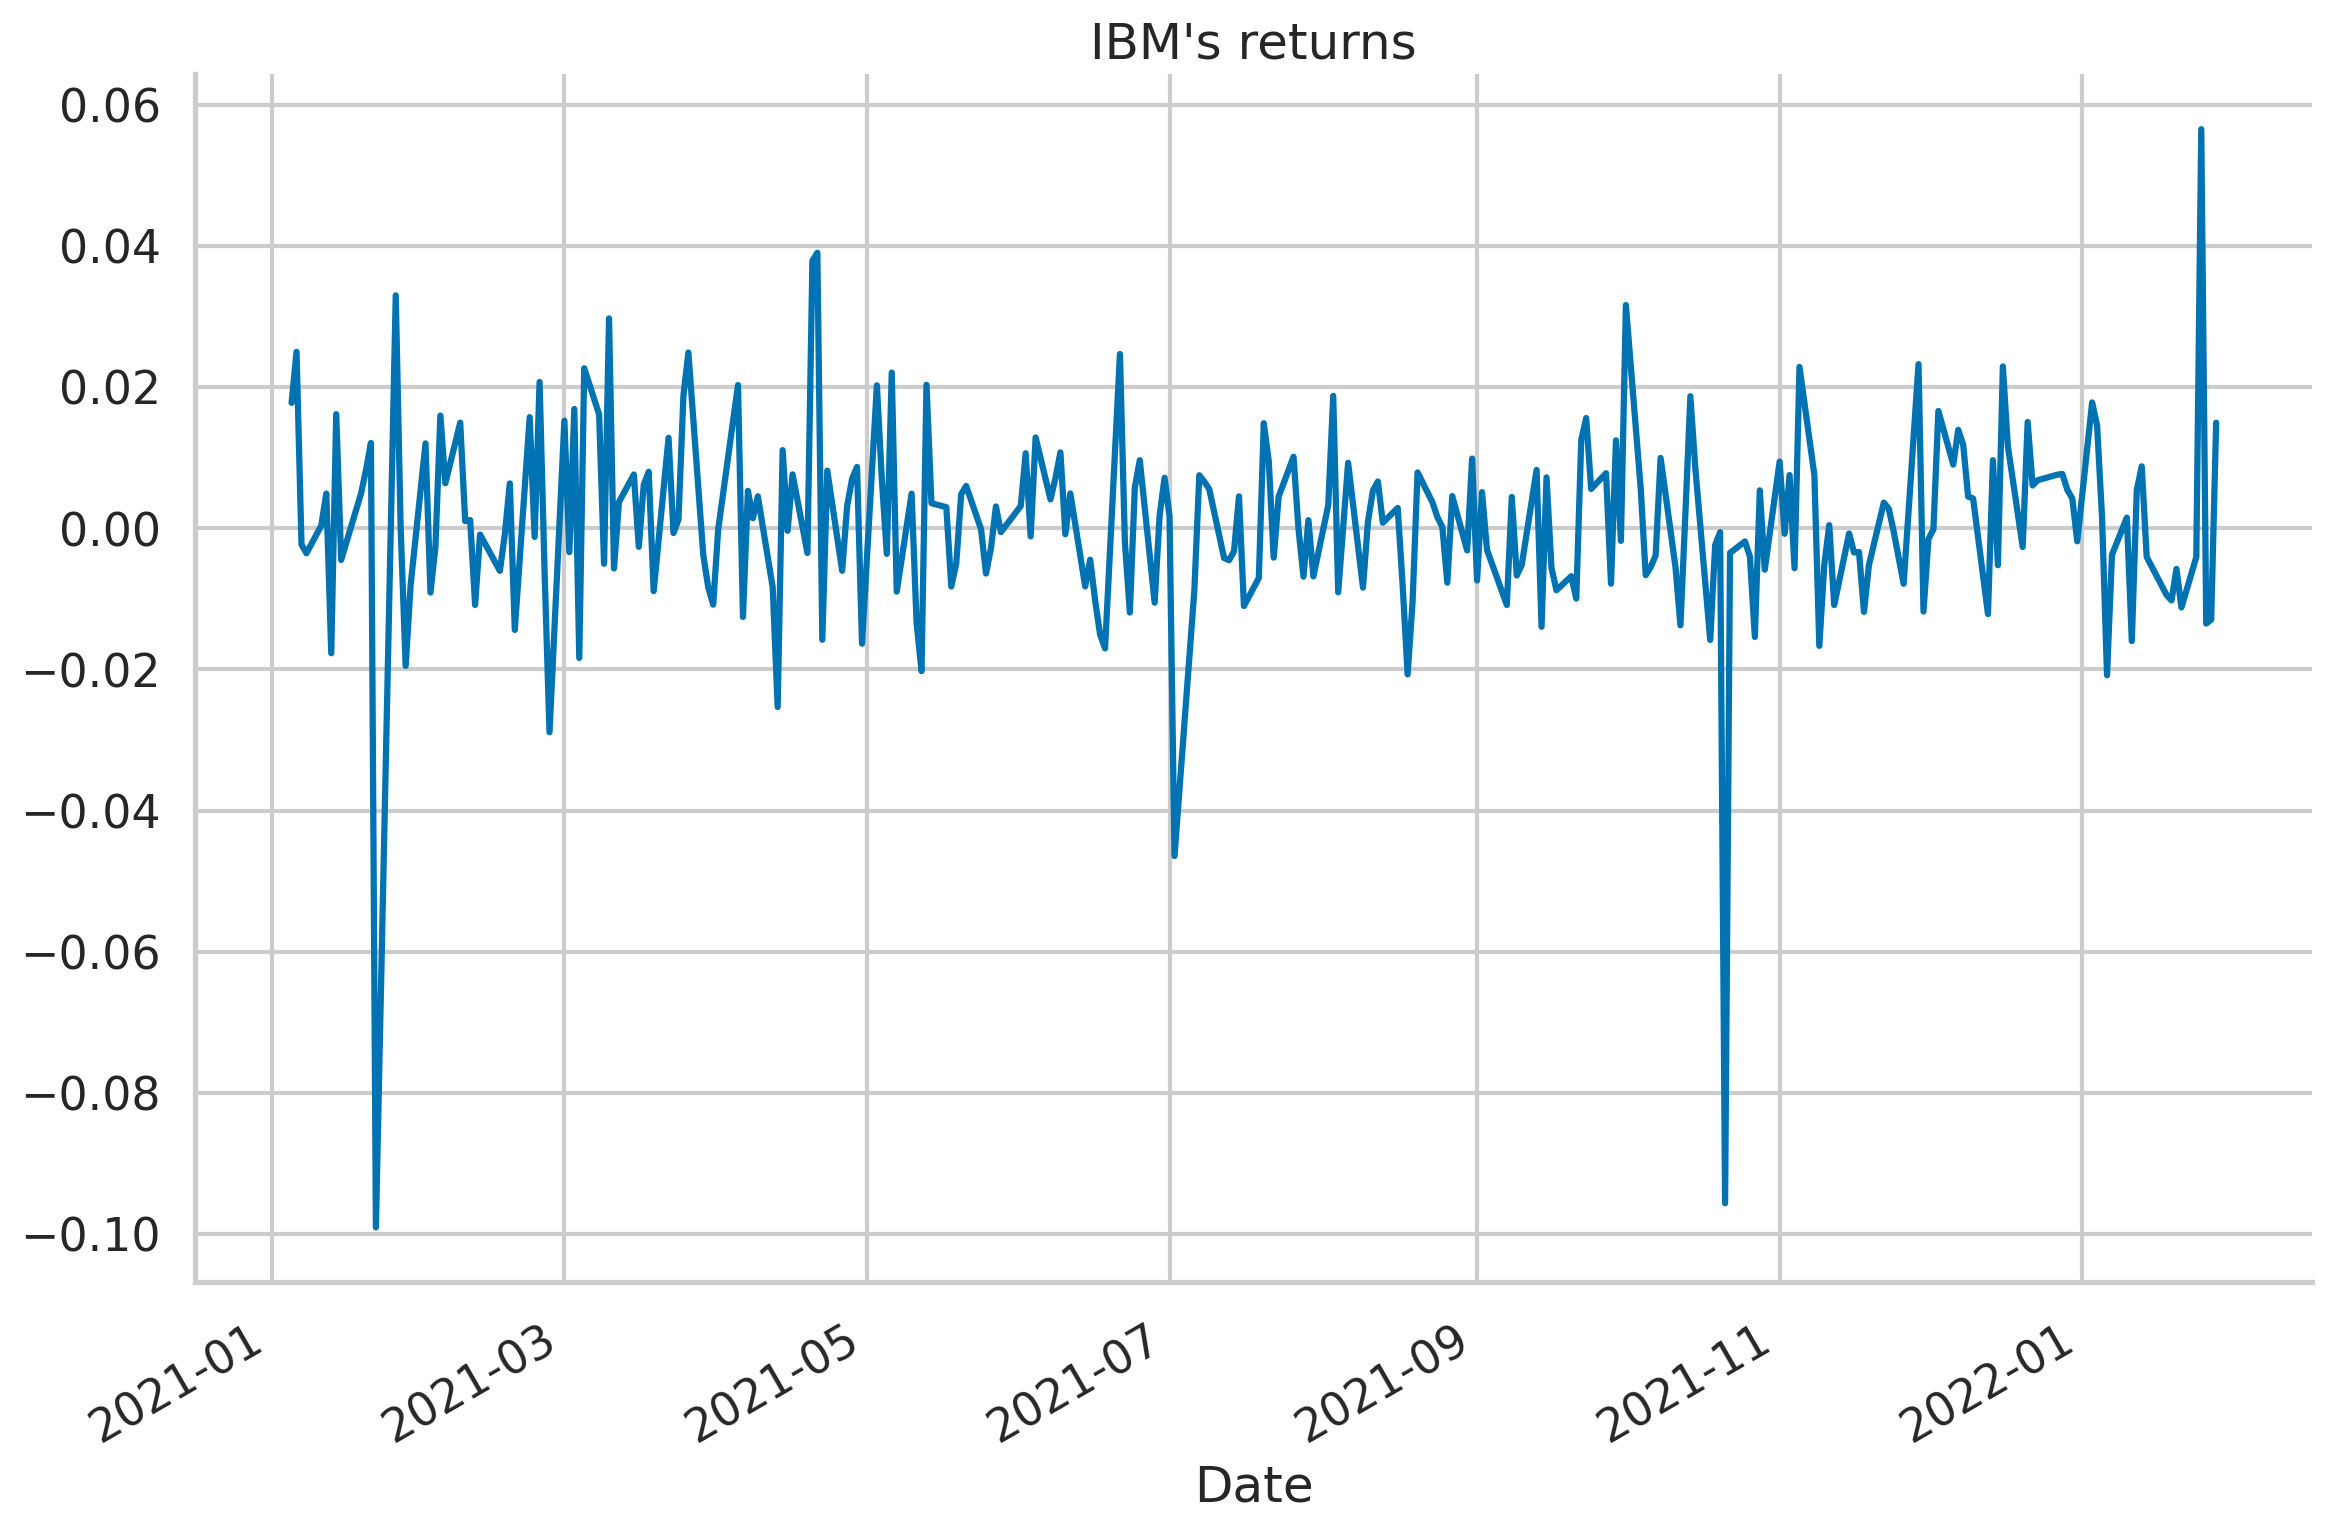

In [7]:
returns = df["Adj Close"].pct_change().dropna()
returns.plot(title="IBM's returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_1", dpi=200)

In [8]:
print(f"Average return: {100 * returns.mean():.2f}%")

Average return: 0.08%


4. Split data into the training and test sets:

다음 단계에서, 데이터를 학습 세트와 테스트 세트로 나눕니다. 여기서는 명시적인 모델 학습이 없지만, 학습 세트를 사용하여 재귀 변환의 평균 및 표준 편차를 계산합니다. 그리고 이러한 값을 사용하여 시뮬레이션에 필요한 드리프트($\mu$)와 확산($\sigma$) 계수를 계산합니다. 

In [9]:
train = returns["2021"]
test = returns["2022"]

5. Specify the parameters of the simulation:

또한, **Step 5에서** 다음의 매개변수를 정의합니다:

- **T**: 예측 수평선; 이 경우 테스트 세트에서의 일 수.
- **N**: 예측 수평선에서의 시간 증가 수. 시뮬레이션에서는 $N = T$로 유지합니다.
- **S_0**: 초기 가격. 이 시뮬레이션에서는 학습 세트에서 가져온 초기 값을 사용합니다.
- **N_SIM**: 시뮬레이션된 경로 수.

Monte Carlo 시뮬레이션은 이산화라는 과정을 사용합니다. 이 아이디어는 금융 자산의 연속적인 가격 책정을 많은 수의 이산 간격으로 나누어 근사하는 것입니다. 그래서 예측 수평선을 고려할 때, 시간 증가 수를 맞추기 위해서도 필요합니다.

In [24]:
T = len(test)
N = len(test)
S_0 = df.loc[train.index[-1], "Adj Close"]
N_SIM = 100
mu = train.mean()
sigma = train.std()

6. Define the function used for simulations:

**Step 6에서**, 우리는 시뮬레이션을 실행하기 위한 함수를 정의합니다. 이러한 문제에 대해 함수를/클래스를 정의하는 것은 좋은 습관입니다. 이는 다음 레시피에서도 유용할 것입니다. 이 함수는 다음 단계들을 실행합니다:

1. 시간 증가($dt$)와 Brownian 증가($dW$)를 정의합니다.
2. Brownian 경로($W$)를 행의 누적 합계로 계산합니다($np.cumsum$).
3. 시간 단계($time\_steps$)를 포함하는 행렬을 생성합니다. 이를 위해, 시뮬레이션의 수평선 내에서 간격이 균일한 배열을 생성합니다. 그런 다음 $np.linspace$ 함수를 사용합니다. 이후 배열을 원하는 모양으로 방송합니다($np.broadcast\_to$).
4. 닫힌 형식의 공식을 사용하여 각 시간 지점에서 주식을 계산합니다.
5. 초기 값을 각 행의 첫 번째 위치에 삽입합니다.

벡터에 시간 단계를 방송할 명시적인 필요는 없습니다. 이는 자동으로 이루어지기 때문입니다. 코드를 더 쉽게 디버깅할 수 있게 해줍니다. 우리는 또한 R과 같은 언어에서는 자동 브로드캐스팅이 없다는 점을 인지해야 합니다.

함수 정의에서, 우리는 드리프트를 $(\mu - 0.5 * \sigma^2) * time\_steps$로, 확산을 $\sigma * W$로 인식할 수 있습니다. 또한 큰 시뮬레이션에서 벡터화된 접근 방식을 따릅니다. 이를 통해 $for$ 루프 작성을 피할 수 있으며, 이는 비효율적일 수 있습니다.


In [11]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    """
    기하 브라운 운동을 사용하여 주식 수익률을 시뮬레이션하는 함수입니다.
    
    매개변수
    ------------
    s_0 : float
        초기 주가
    mu : float
        드리프트 계수 (평균 수익률)
    sigma : float
        변동성 계수 (표준편차)
    n_sims : int
        시뮬레이션 경로의 수
    T : float
        예측 기간의 길이 (단위: 일)
    N : int
        예측 기간 내 시간 증분의 수
    random_seed : int
        재현성을 위한 랜덤 시드

    반환값
    -----------
    S_t : np.ndarray
        시뮬레이션 결과를 포함하는 행렬 (크기: n_sims x (T+1)). 
        행은 샘플 경로를, 열은 시간 지점을 나타냅니다.
    """
    # 랜덤 시드 설정
    np.random.seed(random_seed)
    
    # 시간 증분 계산
    dt = T/N
    # 브라운 운동의 증분 생성
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    # 브라운 운동 경로 계산
    W = np.cumsum(dW, axis=1)
    
    # 시간 단계 생성
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    # 기하 브라운 운동 공식을 사용하여 주가 시뮬레이션
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    # 초기 주가를 첫 번째 열에 삽입
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

7. Run the simulations and store the results in a DataFrame:

**Step 7에서**, 우리는 시뮬레이션을 실행하고 그 결과(샘플 경로)를 DataFrame에 저장합니다. 이 작업을 수행하는 동안, 각 열에 하나의 경로만 있게 하여 데이터를 전치합니다. 이는 $pandas$ DataFrame의 $plot$ 메서드를 사용하는 데 있어 더 간단하게 해줍니다. 적절한 인덱스를 갖기 위해, 우리는 학습 세트의 마지막 관측값의 인덱스와 테스트 세트의 인덱스를 결합하기 위해 $union$ 메서드를 사용합니다.

In [25]:
# 기하 브라운 운동 시뮬레이션 실행
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

# 시뮬레이션 결과를 DataFrame으로 변환
# np.transpose()를 사용하여 각 열이 하나의 시뮬레이션 경로를 나타내도록 함
# index는 훈련 세트의 마지막 날짜와 테스트 세트의 모든 날짜를 포함하도록 설정
sim_df = pd.DataFrame(np.transpose(gbm_simulations), 
                      index=train.index[-1:].union(test.index))

8. Create a DataFrame with the average value for each time step and the corresponding actual stock price:

**Step 8에서**, 우리는 각 시간 지점에서 시뮬레이션된 모든 경로의 평균값으로 예측 주가를 계산하고, 이 결과를 DataFrame에 저장합니다. 그런 다음 해당 날짜에 대한 실제 주가와 결합합니다.

In [26]:
# 시뮬레이션 결과의 평균값 계산
res_df = sim_df.mean(axis=1).to_frame()

# 실제 주가 데이터와 결합
res_df = res_df.join(df["Adj Close"])

# 열 이름 설정
res_df.columns = ["simulation_average", "adj_close_price"]

# 결과 확인 (상위 5개 행 출력)
res_df.head()

# 위 코드는 다음과 같은 작업을 수행합니다:
# 1. 시뮬레이션된 모든 경로의 평균값을 계산합니다.
# 2. 실제 주가 데이터를 시뮬레이션 결과와 결합합니다.
# 3. 열 이름을 의미 있게 설정합니다.
# 4. 결과의 처음 5개 행을 출력하여 데이터를 확인합니다.

,simulation_average,adj_close_price
Date,,
2021-12-31,118.009155,118.009155
2022-01-03,118.191390,120.110474
2022-01-04,118.288699,121.858658
2022-01-05,118.384197,122.035233
2022-01-06,118.482062,119.492455


9. Plot the results of the simulation:

마지막 단계에서는, 시뮬레이션된 경로를 시각화합니다. 경로를 시각화할 때, 투명성을 위해 $alpha=0.3$을 선택하여 두 개의 선(예측된 평균 경로와 실제 경로)을 더 쉽게 볼 수 있도록 합니다.

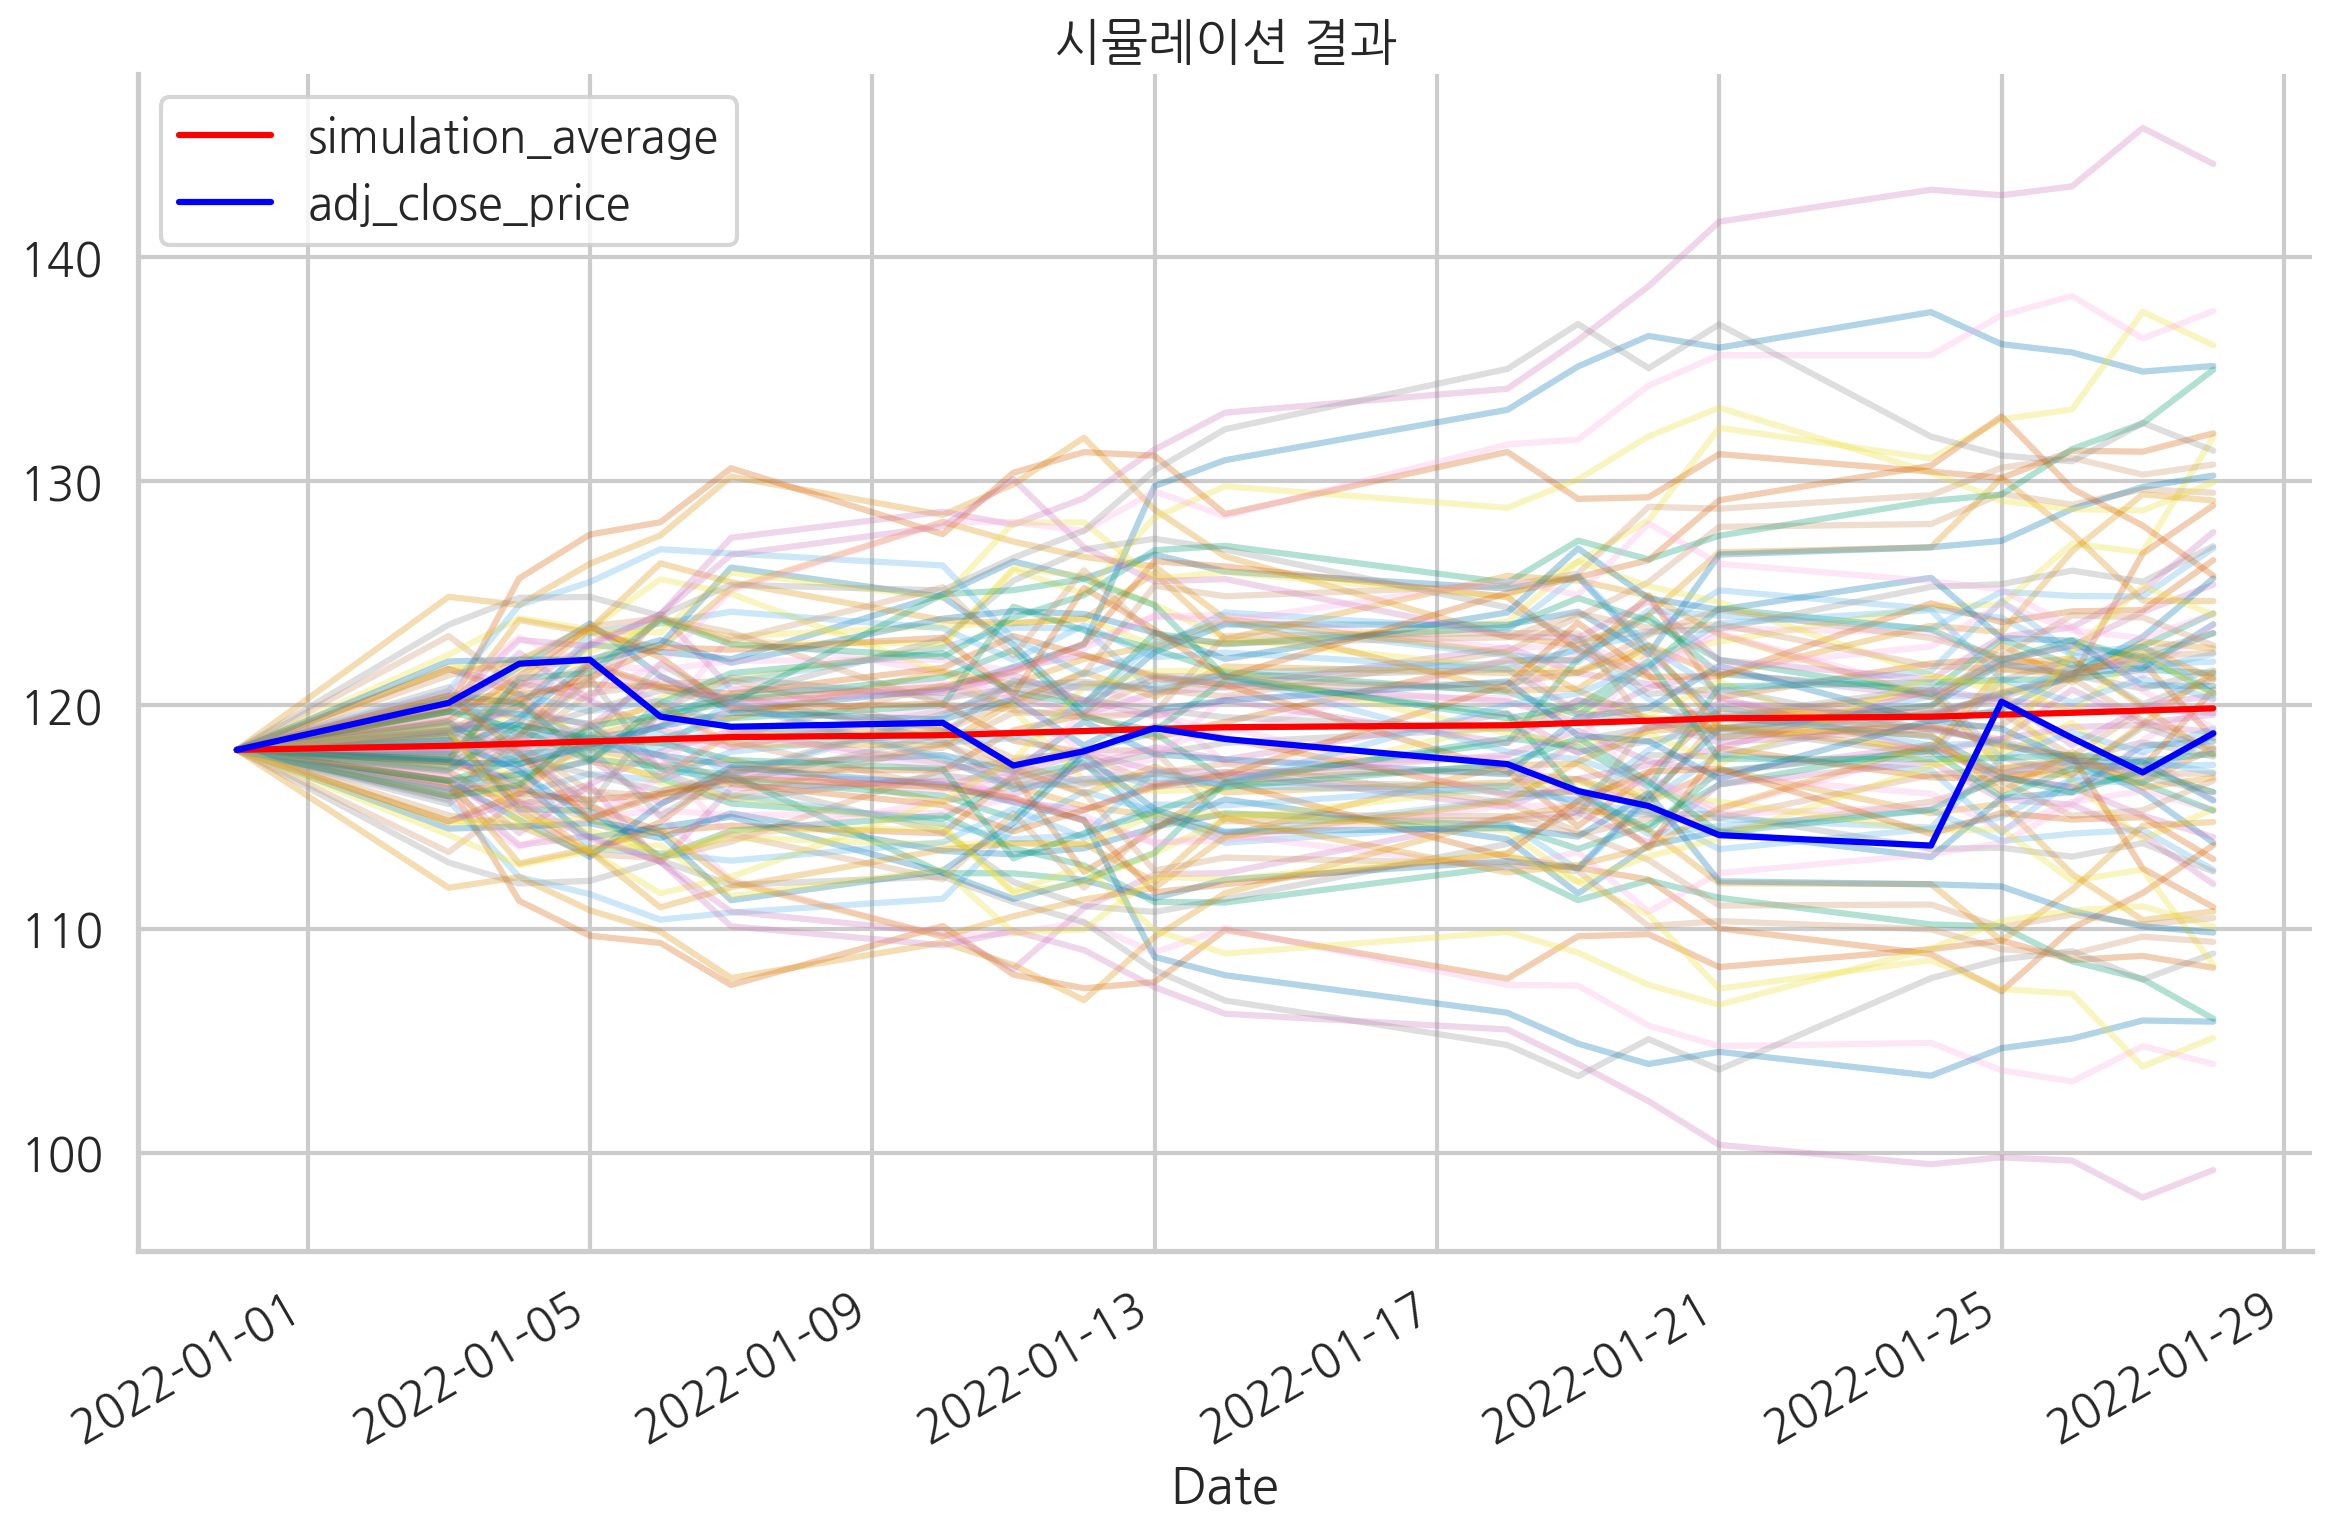

In [27]:
# 시뮬레이션 결과를 시각화합니다
ax = sim_df.plot(
    alpha=0.3,  # 투명도를 0.3으로 설정하여 여러 경로를 겹쳐 표시
    legend=False,  # 범례를 표시하지 않음
    title="시뮬레이션 결과"  # 그래프 제목 설정
)

# 실제 주가와 시뮬레이션 평균을 추가로 플롯
res_df.plot(ax=ax, color = ["red", "blue"])  # 빨간색: 시뮬레이션 평균, 파란색: 실제 주가

# 그래프 스타일 조정
sns.despine()  # 상단과 우측 테두리 제거
plt.tight_layout()  # 그래프 레이아웃 최적화

# 그래프를 이미지 파일로 저장 (현재는 주석 처리됨)
# plt.savefig("images/figure_10_2", dpi=200)

### There's more 


Monte Carlo 시뮬레이션을 더 쉽게 만드는 몇 가지 통계적 방법들이 있습니다(더 높은 정확도, 빠른 계산 속도). 그 중 하나는 **대칭 변수(Antithetic Variates)** 라고 불리는 분산 감소 방법입니다. 이 접근법에서는 추정기의 분산을 줄이기 위해 무작위 추출 쌍 사이에 음의 상관성을 도입하려고 합니다. 이는 다음과 같이 나타납니다: 샘플 경로를 생성할 때, 각 $\epsilon_1, \dots, \epsilon_t$에 대해 반대 부호의 값들, 즉 $-\epsilon_1, \dots, -\epsilon_t$를 함께 사용합니다.

이 접근법의 장점은 다음과 같습니다:

- 경로 $N$을 생성하는 데 필요한 표준 정규 샘플 수를 절반으로 줄입니다.
- 샘플 경로 분산을 줄이면서 동시에 정확도를 향상시킵니다.

우리는 이 접근법을 향상된 **simulate_gbm** 함수에 구현했습니다. 또한 대부분의 계산을 한 줄에 넣어 함수를 더 간결하게 만들었습니다.

이러한 변경을 구현하기 전에, 우리는 함수의 초기 버전을 측정했습니다:

In [18]:
# simulate_gbm 함수의 실행 시간을 측정합니다
# %timeit 매직 명령어를 사용하여 함수 실행 시간의 평균과 표준편차를 계산합니다
# 이는 함수의 성능을 평가하는 데 유용합니다
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

82.4 μs ± 1.19 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, 
                 antithetic_var=False):
    """
    기하 브라운 운동을 사용하여 주식 수익률을 시뮬레이션하는 함수입니다.
    
    매개변수
    ------------
    s_0 : float
        초기 주가
    mu : float
        드리프트 계수
    sigma : float
        확산 계수
    n_sims : int
        시뮬레이션 경로 수
    T : float
        예측 기간의 길이 (dt와 동일한 단위)
    N : int
        예측 기간의 시간 증분 수
    random_seed : int
        재현성을 위한 랜덤 시드
    antithetic_var : bool
        분산을 줄이기 위해 대칭 변수 접근법을 사용할지 여부

    반환값
    -----------
    S_t : np.ndarray
        시뮬레이션 결과를 포함하는 행렬 (크기: n_sims x (T+1)). 
        행은 샘플 경로를, 열은 시간점을 나타냅니다.
    """
    
    # 랜덤 시드 설정
    np.random.seed(random_seed)
    
    # 시간 증분 계산
    dt = T/N
    
    # 브라운 운동 생성
    if antithetic_var:
        # 대칭 변수 접근법 사용 시
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        # 일반적인 경우
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # 주가 과정의 진화 시뮬레이션
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0  # 초기 주가 설정
    
    return S_t

In [29]:
# simulate_gbm 함수의 실행 시간을 측정합니다
# %timeit 매직 명령어를 사용하여 여러 번 실행하고 평균 시간을 계산합니다
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

# S_0: 초기 주가
# mu: 드리프트 계수
# sigma: 확산 계수
# N_SIM: 시뮬레이션 경로 수
# T: 예측 기간의 길이
# N: 예측 기간의 시간 증분 수

49.3 μs ± 58.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
# 대칭 변수 접근법을 사용하여 simulate_gbm 함수의 실행 시간을 측정합니다
# antithetic_var=True 옵션을 사용하여 분산 감소 기법을 적용합니다
# %timeit 매직 명령어를 사용하여 여러 번 실행하고 평균 시간을 계산합니다
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

# S_0: 초기 주가
# mu: 드리프트 계수
# sigma: 확산 계수
# N_SIM: 시뮬레이션 경로 수
# T: 예측 기간의 길이
# N: 예측 기간의 시간 증분 수
# antithetic_var=True: 대칭 변수 접근법 사용 (분산 감소를 위해)

35.1 μs ± 66.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### See also

이 레시피에서는 기하학적 Brownian 운동을 사용하여 주식 가격을 시뮬레이션하는 방법을 보여주었습니다. 그러나 다른 확률 과정도 사용할 수 있으며, 그 중 일부는 다음과 같습니다:

- 점프-확산 모델: Merton, R. “Option Pricing When the Underlying Stock Returns Are Discontinuous,” *Journal of Financial Economics*, 3, 3 (1976): 125–144
- 제곱근 확산 모델: Cox, John, Jonathan Ingersoll, and Stephen Ross, “A theory of the term structure of interest rates,” *Econometrica*, 53, 2 (1985): 385–407
- 확률적 변동성 모델: Heston, S. L., “A closed-form solution for options with stochastic volatility with applications to bond and currency options,” *The Review of Financial Studies*, 6(2): 327–343.

## 10.2 Pricing European options using simulations 

**시뮬레이션을 사용한 유럽식 옵션 가격 책정**

옵션은 파생 상품의 일종으로, 그 가격은 기초 자산의 가격(예: 주식)에 연결되어 있습니다. 옵션 계약을 구매하면, 특정 가격(스트라이크라고 함)으로 특정 날짜 이전 또는 그 날짜에 기초 자산을 매매할 권리(의무는 아님)를 얻게 됩니다. 옵션이 인기가 있는 주요 이유는 자산 가격이 바람직하지 않은 방식으로 움직이는 것을 헤지하는 데 사용되기 때문입니다.

이 레시피에서는 한 가지 유형의 옵션, 즉 유럽식 옵션에 중점을 둡니다. 유럽식 콜/풋 옵션은 특정 만기일(일반적으로 $T$로 표시)에서 특정 자산을 매매할 수 있는 권리를 부여합니다.

옵션 평가에는 여러 가지 방법이 있습니다. 예를 들어:

- 해석적 공식(일부 옵션 유형만 해당)
- 이항 트리 접근법
- 유한 차분법
- Monte Carlo 시뮬레이션

유럽식 옵션은 평가를 위한 해석적 공식이 존재한다는 점에서 예외적입니다. 이는 미국식 옵션이나 이국적인 옵션과 같은 더 복잡한 파생 상품에는 해당되지 않습니다.

Monte Carlo 시뮬레이션을 사용하여 옵션을 평가하기 위해서는 위험 중립 평가를 사용합니다. 이 방법에서는 파생상품의 공정 가치를 미래 수익의 기대값으로 계산합니다. 다시 말해, 옵션 프리미엄이 무위험 이자율과 동일한 비율로 증가한다고 가정하고, 이를 현재 가치로 할인합니다. 시뮬레이션된 경로 각각에 대해, 옵션의 만기 수익을 계산하고, 모든 경로의 평균을 취한 다음, 이를 현재 가치로 할인합니다.

이 레시피에서는 Black-Scholes 모델의 해석적 솔루션을 코딩한 후 Monte Carlo 시뮬레이션 접근 방식을 사용합니다. 단순함을 위해 가상의 입력 데이터를 사용하지만, 실제 데이터를 유사하게 사용할 수 있습니다.

### How to do it...

1. Import the libraries:

In [1]:
import numpy as np
from scipy.stats import norm
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

**Step 2에서**, 우리는 이 레시피에 사용한 매개변수를 정의합니다:

- $S_0$: 초기 주가
- $K$: 스트라이크 가격, 즉 만기 시점에 매매할 수 있는 가격
- $r$: 연간 무위험 이자율
- $\sigma$: 기초 자산 변동성(연간화된 값)
- $T$: 만기까지 남은 시간(년 단위)
- $N$: 시뮬레이션을 위한 시간 증가 수
- $N_{SIM}$: 시뮬레이션된 샘플 경로 수
- $discount\_factor$: 미래 수익을 현재 가치로 계산하는 데 사용되는 할인율

In [2]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1_000_000 # number of simulations 
discount_factor = np.exp(-r * T)

3. Define the valuation function using the analytical solution:

**Step 3에서**, 우리는 Black-Scholes 모델의 해석적 솔루션(배당금을 지급하지 않는 주식의 경우)을 사용하여 옵션 프리미엄을 계산하는 함수를 정의합니다. 

Black-Scholes 모델의 핵심은 옵션의 이론적 가격을 계산하는 수학적 공식입니다. 이 공식은 유럽식 콜 옵션과 풋 옵션에 대해 각각 다음과 같이 표현됩니다:

**유럽식 콜 옵션 가격 공식:**

$ C(S, t) = N(d_1) S - N(d_2) K e^{-r(T-t)} $

**유럽식 풋 옵션 가격 공식:**

$ P(S, t) = N(-d_2) K e^{-r(T-t)} - N(-d_1) S $

여기서:

- $ S $는 현재 주가입니다.
- $ K $는 옵션의 행사가격입니다.
- $ r $는 무위험 이자율입니다.
- $ T $는 옵션의 만기까지 남은 시간(년 단위)입니다.
- $ N(x) $는 표준 정규 분포의 누적 분포 함수(CDF)입니다.
- $ e $는 자연 로그의 밑입니다.
- $ \sigma $는 주식의 변동성(연간화된 표준편차)입니다.

**$ d_1 $과 $ d_2 $의 계산:**

$ d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}} $

$ d_2 = d_1 - \sigma\sqrt{T} $

- **$ N(d_1) $와 $ N(d_2) $**: 이 값들은 옵션이 만기 시점에 행사될 확률을 나타냅니다. $ N(d_1) $는 옵션이 행사될 확률을, $ N(d_2) $는 옵션이 무위험 이자율로 할인된 행사가격보다 높을 확률을 나타냅니다.
  
- **콜 옵션 공식**: 현재 주가에 옵션이 행사될 확률을 곱한 값에서, 할인된 행사가격에 옵션이 행사될 확률을 곱한 값을 뺀 것입니다. 이는 옵션을 행사했을 때의 기대 수익을 나타냅니다.

- **풋 옵션 공식**: 할인된 행사가격에 옵션이 행사될 확률을 곱한 값에서, 현재 주가에 옵션이 행사될 확률을 곱한 값을 뺀 것입니다. 이는 풋 옵션을 행사했을 때의 기대 수익을 나타냅니다.

이 공식들은 옵션의 현재 가치를 계산하는 데 사용되며, 시장에서 거래되는 옵션의 가격을 평가하는 데 중요한 역할을 합니다. Black-Scholes 모델은 이러한 수학적 접근을 통해 옵션 가격을 보다 체계적이고 일관되게 평가할 수 있도록 도와줍니다.

In [4]:
def black_scholes_analytical(S_0, K, T, r, sigma, type="call"):
    """
    블랙-숄즈 모델의 해석적 형태를 사용하여 유럽식 옵션의 가격을 계산하는 함수입니다.

    매개변수
    ------------
    S_0 : float
        초기 주가
    K : float
        행사가격
    T : float
        만기까지의 시간 (년 단위)
    r : float
        연간화된 무위험 이자율
    sigma : float
        주식 수익률의 표준편차 (변동성)
    type : str
        옵션의 유형. "call" 또는 "put" 중 하나여야 합니다.

    반환값
    -----------
    option_premium : float
        블랙-숄즈 모델을 사용하여 계산된 옵션의 프리미엄
    """

    # d1과 d2 계산
    d1 = (np.log(S_0/K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == "call":
        # 콜 옵션의 경우
        N_d1 = norm.cdf(d1, 0, 1)  # d1의 누적 정규분포 값
        N_d2 = norm.cdf(d2, 0, 1)  # d2의 누적 정규분포 값
        val = S_0 * N_d1 - K * np.exp(-r * T) * N_d2  # 콜 옵션 가격 계산
    elif type == "put":
        # 풋 옵션의 경우
        N_d1 = norm.cdf(-d1, 0, 1)  # -d1의 누적 정규분포 값
        N_d2 = norm.cdf(-d2, 0, 1)  # -d2의 누적 정규분포 값
        val = K * np.exp(-r * T) * N_d2 - S_0 * N_d1  # 풋 옵션 가격 계산
    else:
        raise ValueError("옵션 유형이 잘못되었습니다. 'call' 또는 'put'을 입력하세요.")

    return val  # 계산된 옵션 가격 반환


4. Valuate the call option using the specified parameters:


**Step 4에서**, Monte Carlo 시뮬레이션을 위한 기준을 계산할 때 이 함수를 사용합니다.

콜 옵션과 풋 옵션에 대한 해석적 솔루션은 다음과 같습니다:

$
C(S_t, t) = N(d_1) S_t - N(d_2) K e^{-r(T-t)}
$

$
P(S_t, t) = N(-d_2) K e^{-r(T-t)} - N(-d_1) S_t
$

$
d_1 = \frac{1}{\sigma \sqrt{T-t}} \left[ \ln \left( \frac{S_t}{K} \right) + \left( r + \frac{\sigma^2}{2} \right)(T - t) \right]
$

$
d_2 = d_1 - \sigma \sqrt{T-t}
$

여기서 $N(x)$는 표준 정규 분포의 누적 분포 함수(CDF)를 나타내고, $T - t$는 만기까지 남은 시간을 년 단위로 표현한 것입니다. 방정식 1은 유럽식 콜 옵션의 가격을 나타내고, 방정식 2는 유럽식 풋 옵션의 가격을 나타냅니다. 비공식적으로, 방정식 1의 두 항은 다음과 같이 생각할 수 있습니다:

- 현재 주가, 옵션 행사 확률로 가중치가 부여됨 ($N(d_1)$) — 우리가 받을 수 있는 값
- 할인된 행사 가격($strike$), 옵션 행사 확률로 가중치가 부여됨 ($N(d_2)$) — 우리가 지불해야 할 값

In [5]:
# Black-Scholes 해석적 공식을 사용하여 콜 옵션의 가격을 계산합니다.
# S_0: 기초 자산의 현재 가격
# K: 행사가격
# T: 만기까지의 시간 (연 단위)
# r: 무위험 이자율
# sigma: 기초 자산의 변동성
# type: 옵션 유형 ("call" 또는 "put")
black_scholes_analytical(S_0=S_0, K=K, T=T, 
                         r=r, sigma=sigma, 
                         type="call")

np.float64(21.79260421286685)

5. Simulate the stock path using the `simulate_gbm`  function: 

**Step 5에서**, 우리는 이전 레시피에서 정의한 GBM 시뮬레이션 함수를 사용하여 기초 자산의 1,000,000개의 가능한 경로를 얻습니다. 옵션 프리미엄을 계산하기 위해서는 최종 값만을 고려하며, 각 경로에 대해 다음과 같이 수익을 계산합니다:

- 콜 옵션: $ \max(S_T - K, 0) $
- 풋 옵션: $ \max(K - S_T, 0) $

In [6]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

6. Calculate the option's premium:

**Step 6에서**, 우리는 모든 경로에서 수익의 평균을 구하고, 이를 할인율을 사용해 현재 가치로 환산합니다.

In [7]:
premium = (
    discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
)
premium

np.float64(21.756178586245806)

### There's more

**Monte Carlo 시뮬레이션을 사용한 평가 함수 개선**

이전 단계에서 우리는 GBM 시뮬레이션을 재사용하여 유럽식 콜 옵션 프리미엄을 계산하는 방법을 보여주었습니다. 그러나 계산을 더 빠르게 할 수 있습니다. 유럽식 옵션의 경우, 우리는 만기 시점의 주가에만 관심이 있기 때문에 중간 과정은 중요하지 않습니다. 그래서 우리는 만기 시점의 가격만 시뮬레이션하고, 이 값을 사용하여 예상 수익을 계산하면 됩니다. 여기서는 이전에 사용한 동일한 매개변수를 사용하여 유럽식 풋 옵션의 예를 통해 이 방법을 보여줍니다.

우리는 해석적 공식을 사용하여 옵션 프리미엄을 계산하는 것부터 시작합니다:

1. Calculate the option premium for the European put option using the analytical formula:

In [8]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type="put")

np.float64(16.915546662938254)

2. Define the modified simulation function, which only looks at the terminal values of the simulation paths:

In [9]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, 
                               type="call", random_seed=42):
    """
    몬테카를로 시뮬레이션을 사용하여 유럽식 옵션의 가격을 계산하는 함수입니다.
    
    매개변수:
    ------------
    S_0 : float
        초기 주식 가격
    K : float
        행사가격
    T : float
        만기까지의 시간 (연 단위)
    r : float
        연간 무위험 이자율
    sigma : float
        주식 수익률의 표준편차
    n_sims : int
        시뮬레이션할 경로의 수
    type : str
        옵션의 종류. "call" 또는 "put" 중 하나여야 합니다.
    random_seed : int
        재현성을 위한 랜덤 시드
        
    반환값:
    -----------
    option_premium : float
        몬테카를로 시뮬레이션을 통해 계산된 옵션의 프리미엄
    """
    # 랜덤 시드 설정
    np.random.seed(random_seed)
    
    # 표준 정규 분포에서 난수 생성
    rv = np.random.normal(0, 1, size=n_sims)
    
    # 기하 브라운 운동을 사용하여 만기 시점의 주가 계산
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    # 옵션 종류에 따른 페이오프 계산
    if type == "call":
        payoff = np.maximum(0, S_T - K)  # 콜 옵션의 페이오프
    elif type == "put":
        payoff = np.maximum(0, K - S_T)  # 풋 옵션의 페이오프
    else: 
        raise ValueError("옵션 종류는 'call' 또는 'put'이어야 합니다!")
    
    # 옵션 프리미엄 계산: 페이오프의 평균을 현재 가치로 할인
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

3. Run the simulations for the European put option:

In [10]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type="put")

np.float64(16.948225203893127)

**그리스 문자를 사용한 가격 민감도 측정**

옵션 평가를 논할 때, 파생 상품 가격의 민감도를 나타내는 유명한 그리스 문자들(Greeks)을 언급하는 것도 중요합니다. 이 민감도는 일반적으로 그리스 문자를 사용하여 표기되며, 다음은 가장 많이 사용되는 다섯 가지 민감도입니다:

- **델타(Δ)**: 기초 자산 가격 변화에 대한 이론적 옵션 가치의 민감도
- **베가(V)**: 기초 자산의 변동성에 대한 이론적 옵션 가치의 민감도
- **세타(Θ)**: 옵션의 만기 시간에 대한 이론적 옵션 가치의 민감도
- **로(Ρ)**: 이자율에 대한 이론적 옵션 가치의 민감도
- **감마(Γ)**: 이차 그리스 문자의 예로, 기초 자산 가격 변화에 대한 옵션 델타(Δ)의 민감도를 나타냅니다

다음 표는 우리가 이미 사용한 값을 기준으로 유럽식 콜 옵션과 풋 옵션의 그리스 문자가 어떻게 표현되는지를 보여줍니다:

| What   | Calls                                     | Puts                                      |
|--------|-------------------------------------------|-------------------------------------------|
| 델타   | $N(d_1)$                                | $N(d_1) - 1$                            |
| 감마   | $\frac{N'(d_1)}{S_t \sigma \sqrt{T-t}}$ | $\frac{N'(d_1)}{S_t \sigma \sqrt{T-t}}$ |
| 베가   | $S_t \sqrt{T - t} N'(d_1)$              | $S_t \sqrt{T - t} N'(d_1)$              |
| 세타   | $\frac{-S_t N'(d_1) \sigma}{2 \sqrt{T - t}} - r K e^{-r(T-t)} N(d_2)$ | $\frac{-S_t N'(d_1) \sigma}{2 \sqrt{T - t}} + r K e^{-r(T-t)} N(-d_2)$ |
| 로     | $K(T - t) e^{-r(T-t)} N(d_2)$           | $-K(T - t) e^{-r(T-t)} N(-d_2)$         |

여기서 $N'(x)$는 표준 정규 분포의 확률 밀도 함수(PDF)를 나타냅니다. 보시다시피, 그리스 문자는 유럽식 콜 또는 풋 옵션의 가격에 대한 모델 매개변수의 편미분으로 표현됩니다. 또한, 그리스 문자는 모델에 따라 다르다는 점을 유념해야 합니다.

## 10.3 Pricing American options with Least Squares Monte Carlo

**최소제곱 몬테카를로(Least Squares Monte Carlo)를 사용한 미국식 옵션 가격 책정**

이 레시피에서는 미국식 옵션을 평가하는 방법을 배웁니다. 유럽식 옵션과 미국식 옵션의 주요 차이점은 후자는 만기일까지 언제든지 행사될 수 있다는 점입니다. 즉, 옵션 보유자에게 유리한 시점에 기초 자산의 가격이 움직이면 언제든지 행사할 수 있습니다.

이러한 특성은 평가에 추가적인 복잡성을 도입하며, 이 문제에는 폐쇄형 솔루션이 없습니다. Monte Carlo 시뮬레이션을 사용할 때는 각 샘플 경로에서 최종 값만을 볼 수 없습니다. 옵션의 행사는 경로 어디에서든지 발생할 수 있기 때문입니다. 그래서 더 정교한 접근 방식인 **최소제곱 몬테카를로(LSMC)**를 사용해야 합니다. 이 방법은 Longstaff와 Schwartz(2001)에 의해 소개되었습니다.

우선, $[0, T]$ 기간을 동일하게 나눈 유한한 수의 간격으로 이산화하고, 조기 행사는 특정한 시간 단계에서만 발생할 수 있습니다. 실질적으로, 미국식 옵션은 버뮤다 옵션으로 근사됩니다. 임의의 시간 단계 $t$에서, 조기 행사는 즉각적인 행사의 수익이 지속 가치보다 클 때 수행됩니다.

이는 다음 공식으로 표현됩니다:

$
V_t(s) = \max \left( h_t(s), C_t(s) \right)
$

여기서, $h_t(s)$는 옵션의 수익(유럽식 옵션의 경우와 마찬가지로 내부 가치라고도 불립니다), $C_t(s)$는 옵션의 지속 가치로 다음과 같이 정의됩니다:

$
C_t(s) = E_t^Q \left[ e^{-r dt} V_{t+dt} | S_t = s \right]
$

여기서, $r$은 무위험 이자율이며, $dt$는 시간 증가입니다. 지속 가치는 주어진 시간에서 옵션을 행사하지 않는 경우의 예상 수익입니다.

Monte Carlo 시뮬레이션을 사용할 때, 우리는 각 경로 $i$와 시간 $t$에 대해 $e^{-r dt} V_{t+dt,i}$ 값을 정의할 수 있습니다. 그러나 이 값을 직접 사용하는 것은 완벽한 예견을 의미하기 때문에 불가능합니다. 그래서 LSMC 알고리즘은 선형 회귀를 사용하여 예상 지속 가치를 추정합니다. 이 때, 옵션을 유지함으로써 발생하는 할인된 미래 값을 기초 자산의 가격에 대한 기저 함수 세트에 회귀시킵니다(시간 $t$ 가격). 이때 가장 간단한 방법은 x차 다항 회귀를 사용하는 것이며, 다른 기저 함수로는 Legendre, Hermite, Chebyshev, Gegenbauer, 또는 Jacobi 다항식 등이 있습니다.

이 알고리즘을 시간 $T-1$에서 0까지 역으로 반복하며, 마지막 단계에서 평균 할인 값을 옵션 프리미엄으로 계산합니다. 유럽식 옵션의 프리미엄은 미국식 옵션의 하한을 나타냅니다. 차이는 일반적으로 조기 행사의 프리미엄이라고 불립니다.

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
from chapter_10_utils import (simulate_gbm, 
                              black_scholes_analytical, 
                              lsmc_american_option)

2. Define the parameters:

**Step 2에서**, 우리는 다시 한 번 고려 중인 미국식 옵션의 매개변수를 정의합니다. 비교를 위해, 우리는 Longstaff와 Schwartz(2001)가 사용한 것과 동일한 값을 가져옵니다. 

In [ ]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = "put"
POLY_DEGREE = 5 

3. Simulate the stock prices using GBM:

**Step 3에서**, 우리는 이전 레시피에서 사용한 **simulate_gbm** 함수를 사용하여 주식의 진화를 시뮬레이션합니다. 

In [ ]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

4. Calculate the payoff matrix:

그 후, 유럽식 옵션에 사용한 것과 동일한 공식을 사용하여 풋 옵션의 수익 행렬을 계산합니다.

In [ ]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

5. Define the value matrix and fill in the last column (time T):

**Step 5에서**, 우리는 시간에 따른 옵션 값을 행렬로 준비합니다. 이 행렬은 수익 행렬과 동일한 크기의 0으로 정의된 행렬입니다. 마지막 열에는 더 이상 계산할 것이 없으므로 유럽식 옵션과 동일한 값을 채웁니다.

In [ ]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

6. Iteratively calculate the continuation value and the value vector in the given time:

**Step 6에서**, 우리는 시간 $T-1$에서 0까지 알고리즘의 역방향 부분을 실행합니다. 각 단계에서, 우리는 교차 섹션 선형 회귀로 예상 지속 가치를 추정합니다. 우리는 **np.polyfit**을 사용하여 데이터를 5차 다항식에 맞춥니다.

그 후, 우리는 특정 값에서 다항식을 평가합니다(즉, **np.polyval** 사용). 이는 선형 회귀에서 얻은 적합 값과 동일합니다. 우리가 예상 지속 가치를 수익과 비교하여, 수익이 더 높으면 옵션을 행사하고, 그렇지 않으면 할인된 한 단계 앞선 값을 설정합니다. 이를 위해 **np.where**를 사용합니다.

>**scikit-learn**을 사용하여 다항식 맞춤을 수행할 수도 있습니다. 이를 위해서는 **LinearRegression**과 **PolynomialFeatures**를 결합해야 합니다.

In [ ]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

7. Calculate the option's premium:

**Step 7에서**, 우리는 할인된 $t = 1$ 값 벡터의 평균값을 취하여 옵션 프리미엄을 얻습니다.

In [ ]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
option_premium

8. Calculate the premium of a European put with the same parameters:

마지막 두 단계에서, 우리는 몇 가지 검사를 수행했습니다. 첫 번째로, 동일한 매개변수를 사용하여 유럽식 풋 옵션의 프리미엄을 계산했습니다. 두 번째로, 모든 단계를 반복하여 동일한 매개변수를 사용하여 미국식과 유럽식 콜 옵션의 프리미엄을 계산했습니다. 이를 더 쉽게 하기 위해, 우리는 LSMC 알고리즘 전체를 하나의 함수로 넣었고, 이 함수는 이 책의 GitHub 저장소에서 사용할 수 있습니다.

콜 옵션의 경우, 미국식 옵션과 유럽식 옵션의 프리미엄은 동일해야 합니다. 배당금이 없으면 옵션을 행사하는 것이 최적이 아니기 때문입니다. 우리의 결과는 매우 유사하지만, 시뮬레이션된 샘플 경로 수를 늘려 더 정확한 가격을 얻을 수 있습니다. Longstaff-Schwartz 알고리즘은 본질적으로 미국식 옵션 가격을 낮게 평가하는 경향이 있습니다. 이는 기저 함수에 의한 지속 가치의 근사가 단순히 근사치일 뿐이라는 사실에서 비롯됩니다. 결과적으로, 알고리즘이 항상 최적의 시점에 옵션 행사를 결정하지는 않습니다.

In [ ]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type="put")

9. As an extra check, calculate the prices of the American and European call options:

In [ ]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type="call", 
                                           poly_degree=POLY_DEGREE)
print(f"European call's price: {european_call_price:.3f}")
print(f"American call's price: {american_call_price:.3f}")

### See also
추가 자료는 다음에서 확인할 수 있습니다:

- Longstaff, F. A., & Schwartz, E. S. 2001. “Valuing American options by simulation: a simple least-squares approach,” *The Review of Financial Studies*, 14(1): 113-147.
- Broadie, M., Glasserman, P., & Jain, G. 1997. “An alternative approach to the valuation of American options using the stochastic tree method,” *Journal of Derivatives*, 5: 25-44.


## 10.4 Pricing American options using Quantlib

이전 레시피에서는 Longstaff-Schwartz 알고리즘을 수동으로 코딩하는 방법을 보여주었습니다. 그러나 파생상품 평가를 위해 이미 존재하는 프레임워크를 사용할 수도 있습니다. 그 중 가장 인기 있는 것 중 하나는 **QuantLib**입니다. QuantLib은 금융 상품 평가 도구를 제공하는 오픈 소스 C++ 라이브러리입니다. Simplified Wrapper and Interface Generator (SWIG)를 사용하면 Python(그리고 R 또는 Julia와 같은 다른 프로그래밍 언어)에서 QuantLib을 사용할 수 있습니다. 이 레시피에서는 이전 레시피에서 가격을 계산했던 미국식 풋 옵션을 QuantLib을 사용하여 가격 책정하는 방법을 보여줍니다. 그러나 이 라이브러리는 그 외에도 탐구할 만한 더 많은 흥미로운 기능들을 제공합니다.

### Getting ready

This setup is the same as Step 2 in the previous recipe.

우리가 이전 레시피에서 얻은 결과와 비교하고자 했기 때문에, 동일한 문제 설정을 사용했습니다. 간결성을 위해 전체 코드를 다루지는 않겠지만, 이전 레시피에서 **Step 2**를 실행해야 합니다.

In [ ]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
N = 50
N_SIMS = 10 ** 5 
OPTION_TYPE = "put"
POLY_DEGREE = 5 

### How to do it...

1. Import the library:

In [ ]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

**Step 2에서**, 우리는 달력과 일 수 계산 규칙을 지정합니다. 일 수 계산 규칙은 채권과 같은 다양한 금융 상품에 대해 이자가 시간이 지남에 따라 어떻게 축적되는지를 결정합니다. **actual/actual** 규칙은 실제 경과 일수를 사용하고, 1년의 실제 일수를 기준으로 계산합니다. 이 외에도 **actual/365 (fixed)**, **actual/360** 등 여러 규칙이 있습니다.


In [ ]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

3. Specify the valuation date and the expiry date of the option:

In [ ]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [ ]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

4. Define the option type (call/put), type of exercise and the payoff:

In [ ]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [ ]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [ ]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [ ]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for the American options:

In [ ]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=42, 
                             requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [ ]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [ ]:
option_premium_ql = option.NPV()
option_premium_ql

In [ ]:
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

### There's more

In [ ]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

## 10.5 Pricing barrier options

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

In [ ]:
S_0 = 55
K = 60
BARRIER = 65 
r = 0.06
sigma = 0.2
T = 1 
N = 252 
dt = T / N 
N_SIMS = 10 ** 5
OPTION_TYPE = "call"
discount_factor = np.exp(-r * T)

3. Simulate the stock path using the `simulate_gbm`  function: 

In [ ]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

4. Calculate the maximum value per path:

In [ ]:
max_value_per_path = np.max(gbm_sims, axis=1)

5. Calculate the payoff:

In [ ]:
payoff = np.where(max_value_per_path > BARRIER, 
                  np.maximum(0, gbm_sims[:, -1] - K), 
                  0)

6. Calculate the option's premium:

In [ ]:
premium = discount_factor * np.mean(payoff)
premium

### There's more

1. Import the library:

In [ ]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [ ]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

3. Specify the valuation date and the expiry date of the option:

In [ ]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [ ]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

4. Define the option type (call/put), type of exercise and the payoff:

In [ ]:
if OPTION_TYPE == "call":
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == "put":
    option_type_ql = ql.Option.Put
        
exercise = ql.EuropeanExercise(expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [ ]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [ ]:
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [ ]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for barrier options:

In [ ]:
engine = ql.MCBarrierEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                            seed=42, 
                            requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [ ]:
option = ql.BarrierOption(ql.Barrier.UpIn, BARRIER, rebate=0, 
                          payoff=payoff, exercise=exercise)
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [ ]:
option_premium_ql = option.NPV()
option_premium_ql

## 11.6 Estimating Value-at-risk using Monte Carlo

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [ ]:
# set random seed for reproducibility
np.random.seed(42)

2. Define the parameters that will be used for this recipe:

In [ ]:
RISKY_ASSETS = ["AMD", "INTC"]
SHARES = [5, 5]
START_DATE = "2020-01-01"
END_DATE = "2020-12-31"
T = 1
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [ ]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)

In [ ]:
df.head()

4. Calculate daily returns:

In [ ]:
returns = df["Adj Close"].pct_change().dropna()
returns.plot(title="Intel's and AMD's daily stock returns in 2020")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_3", dpi=200)

In [ ]:
print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

5. Calculate the covariance matrix:

In [ ]:
cov_mat = returns.cov()
cov_mat

6. Perform the Cholesky decomposition of the covariance matrix:

In [ ]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

7. Draw correlated random numbers from Standard Normal distribution:

In [ ]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

In [ ]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = df["Adj Close"].values[-1, :]
P_0 = np.sum(SHARES * S_0)

9. Calculate the terminal price of the considered stocks:

In [ ]:
S_T = S_0 * np.exp(
    (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv
)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

In [ ]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

11. Calculate VaR:

In [ ]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: {-y:.2f}$")

12. Present the results on a graph:

In [ ]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title("""Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR""", fontsize=16)
ax.axvline(var[2], 0, 10000)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_4", dpi=200)

### There's more

In [ ]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')